In [19]:
%load_ext autotime

# Writing a chess program in one day

The post is about how to write a simple computer chess program within one day with only a few lines of code. The program will be written in Python and contains all main parts of a chess engine. It will be the basis of refinements and enhancements which I will show in future postings.

Every chess program has 3 important parts:
    - The representation of the board
    - The board evaluation
    - The search

As a starting point I use the Python package "chess" [https://python-chess.readthedocs.io](https://python-chess.readthedocs.io) which is a library for move generation, move validation, support for printing the board and more.

## Board representation

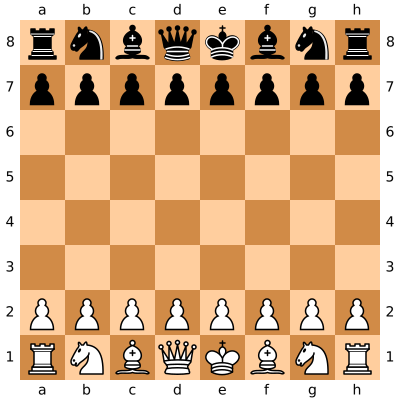

In [1]:
import chess
import chess.svg

from IPython.display import SVG

board = chess.Board()
SVG(chess.svg.board(board=board,size=400))  

The main component of the chess library is a "Board"-object which represents the pieces on the chess board, and has methods for move-generation and checking the status of the board (for example checking for mate). The object has a move-stack on which you can push and pop moves, for making a move and taking back a move.

An SVG component can be used to display a graphical representation of the board as above in a "Jupyter"-notebook.

## Board evaluation

A position on the chess board can be evaluated, if it is won by one side or it is a draw. If none of this conditions is satisfied we need an estimate of how likely it is that a player wins. In this simple implementation it is done by two factors the "material" (pieces on board) and the positions of the pieces. For each sort of pieces different values are calculated depending on the squares the pieces are located. This is done with so called "piece-square" tables. See below for the implementation.

In [3]:
def evaluate_board():
    
    if board.is_checkmate():
        if board.turn:
            return -9999
        else:
            return 9999
    if board.is_stalemate():
        return 0
    if board.is_insufficient_material():
        return 0
    
    wp = len(board.pieces(chess.PAWN, chess.WHITE))
    bp = len(board.pieces(chess.PAWN, chess.BLACK))
    wn = len(board.pieces(chess.KNIGHT, chess.WHITE))
    bn = len(board.pieces(chess.KNIGHT, chess.BLACK))
    wb = len(board.pieces(chess.BISHOP, chess.WHITE))
    bb = len(board.pieces(chess.BISHOP, chess.BLACK))
    wr = len(board.pieces(chess.ROOK, chess.WHITE))
    br = len(board.pieces(chess.ROOK, chess.BLACK))
    wq = len(board.pieces(chess.QUEEN, chess.WHITE))
    bq = len(board.pieces(chess.QUEEN, chess.BLACK))
    
    material = 100*(wp-bp)+320*(wn-bn)+330*(wb-bb)+500*(wr-br)+900*(wq-bq)
    
    pawnsq = sum([pawntable[i] for i in board.pieces(chess.PAWN, chess.WHITE)])
    pawnsq= pawnsq + sum([-pawntable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.PAWN, chess.BLACK)])
    knightsq = sum([knightstable[i] for i in board.pieces(chess.KNIGHT, chess.WHITE)])
    knightsq = knightsq + sum([-knightstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.KNIGHT, chess.BLACK)])
    bishopsq= sum([bishopstable[i] for i in board.pieces(chess.BISHOP, chess.WHITE)])
    bishopsq= bishopsq + sum([-bishopstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.BISHOP, chess.BLACK)])
    rooksq = sum([rookstable[i] for i in board.pieces(chess.ROOK, chess.WHITE)]) 
    rooksq = rooksq + sum([-rookstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.ROOK, chess.BLACK)])
    queensq = sum([queenstable[i] for i in board.pieces(chess.QUEEN, chess.WHITE)]) 
    queensq = queensq + sum([-queenstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.QUEEN, chess.BLACK)])
    kingsq = sum([kingstable[i] for i in board.pieces(chess.KING, chess.WHITE)]) 
    kingsq = kingsq + sum([-kingstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.KING, chess.BLACK)])
    
    eval = material + pawnsq + knightsq + bishopsq+ rooksq+ queensq + kingsq
    if board.turn:
        return eval
    else:
        return -eval

The function returns -9999 if white is mated, 9999 if black is mated and 0 for a draw. In all other situations it returns an evaluation as the sum of the material and the sum of postion values via piece-square tables. If black is in turn then the negative value is returned as needed by the negamax implementation of the search (see below).

### Piece-square tables

I used the piece-squre tables from [https://www.chessprogramming.org/Simplified_Evaluation_Function](https://www.chessprogramming.org/Simplified_Evaluation_Function). For each sort of piece a different table is defined. If the value on a square is positive then the program tries to place a piece on that square if the value is negative it avoids to move to that square. The value of the whole position is calculated by summing over all pieces of both sides.

For pawns the program is encouraged to advance the pawns. Additionally we try to discourage the engine from leaving central pawns unmoved. Pawns on f2, g2 or c2 and b2 should not move zu f3 etc.

Knights are simply encouraged to go to the center. Standing on the edge is a bad idea.

Bishops should avoid corners and borders.

Rooks should occupy the 7th rank and avoid a, h columns

Queens should avoid corners and borders and stay in the center.

Kings should stand behind the pawn shelter. This is only good for opening and middle game. The endgame needs a different table. I will do this in a future enhancement of the program.

In [4]:
pawntable = [
 0,  0,  0,  0,  0,  0,  0,  0,
 5, 10, 10,-20,-20, 10, 10,  5,
 5, -5,-10,  0,  0,-10, -5,  5,
 0,  0,  0, 20, 20,  0,  0,  0,
 5,  5, 10, 25, 25, 10,  5,  5,
10, 10, 20, 30, 30, 20, 10, 10,
50, 50, 50, 50, 50, 50, 50, 50,
 0,  0,  0,  0,  0,  0,  0,  0]

knightstable = [
-50,-40,-30,-30,-30,-30,-40,-50,
-40,-20,  0,  5,  5,  0,-20,-40,
-30,  5, 10, 15, 15, 10,  5,-30,
-30,  0, 15, 20, 20, 15,  0,-30,
-30,  5, 15, 20, 20, 15,  5,-30,
-30,  0, 10, 15, 15, 10,  0,-30,
-40,-20,  0,  0,  0,  0,-20,-40,
-50,-40,-30,-30,-30,-30,-40,-50]

bishopstable = [
-20,-10,-10,-10,-10,-10,-10,-20,
-10,  5,  0,  0,  0,  0,  5,-10,
-10, 10, 10, 10, 10, 10, 10,-10,
-10,  0, 10, 10, 10, 10,  0,-10,
-10,  5,  5, 10, 10,  5,  5,-10,
-10,  0,  5, 10, 10,  5,  0,-10,
-10,  0,  0,  0,  0,  0,  0,-10,
-20,-10,-10,-10,-10,-10,-10,-20]

rookstable = [
  0,  0,  0,  5,  5,  0,  0,  0,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
  5, 10, 10, 10, 10, 10, 10,  5,
 0,  0,  0,  0,  0,  0,  0,  0]

queenstable = [
-20,-10,-10, -5, -5,-10,-10,-20,
-10,  0,  0,  0,  0,  0,  0,-10,
-10,  5,  5,  5,  5,  5,  0,-10,
  0,  0,  5,  5,  5,  5,  0, -5,
 -5,  0,  5,  5,  5,  5,  0, -5,
-10,  0,  5,  5,  5,  5,  0,-10,
-10,  0,  0,  0,  0,  0,  0,-10,
-20,-10,-10, -5, -5,-10,-10,-20]

kingstable = [
 20, 30, 10,  0,  0, 10, 30, 20,
 20, 20,  0,  0,  0,  0, 20, 20,
-10,-20,-20,-20,-20,-20,-20,-10,
-20,-30,-30,-40,-40,-30,-30,-20,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30]

## Search

For lookahead I use Depth-First search that starts at the root and explores up to a fixed depth along each branch before backtracking. The value of the position is calculated via [Minimax](https://www.chessprogramming.org/Minimax) and [Alphabeta pruning](https://www.chessprogramming.org/Alpha-Beta) is used with the Negamax implementation.  

In [5]:
def alphabeta( alpha, beta, depthleft ):
    bestscore = -9999
    if( depthleft == 0 ):
        return quiesce( alpha, beta )
    for move in board.legal_moves:
        board.push(move)   
        score = -alphabeta( -beta, -alpha, depthleft - 1 )
        board.pop()
        if( score >= beta ):
            return score
        if( score > bestscore ):
            bestscore = score
        if( score > alpha ):
            alpha = score   
    return bestscore

At the maximun search depth the search is extended by searching all capture moves, the so called [quiescence search](https://www.chessprogramming.org/Quiescence_Search) to avoid the ["Horizon Effect"](https://www.chessprogramming.org/Horizon_Effect).

In [6]:
def quiesce( alpha, beta ):
    stand_pat = evaluate_board()
    if( stand_pat >= beta ):
        return beta
    if( alpha < stand_pat ):
        alpha = stand_pat

    for move in board.legal_moves:
        if board.is_capture(move):
            board.push(move)        
            score = -quiesce( -beta, -alpha )
            board.pop()

            if( score >= beta ):
                return beta
            if( score > alpha ):
                alpha = score  
    return alpha

The function which implements the move selection in the root position consists of two parts. The first part tries to find a move in the opening book and gives it back. The "chess" library has a function to access opening books in the ["Polyglot" format](https://www.chessprogramming.org/PolyGlot). I used the "bookfish" opening book which I downloaded from [http://rebel13.nl/download/books.html](http://rebel13.nl/download/books.html). A random weighted move is selected from all possible moves of the book in this position.

The second part calculates the move if the book is empty. For each move in the position the search (alphabeta) is conducted and the best move is choosen.

In [7]:
import chess.polyglot

def selectmove(depth):
    try:
        move = chess.polyglot.MemoryMappedReader("bookfish.bin").weighted_choice(board).move()
        movehistory.append(move)
        return move
    except:
        bestMove = chess.Move.null()
        bestValue = -99999
        alpha = -100000
        beta = 100000
        for move in board.legal_moves:
            board.push(move)
            boardValue = -alphabeta(-beta, -alpha, depth-1)
            if boardValue > bestValue:
                bestValue = boardValue;
                bestMove = move
            if( boardValue > alpha ):
                alpha = boardValue
            board.pop()
        movehistory.append(bestMove)
        return bestMove

To play against the program inside a Jupyter notebook you can evalute the following cell to compute a computer move (with a search depth of 3), and display the board.

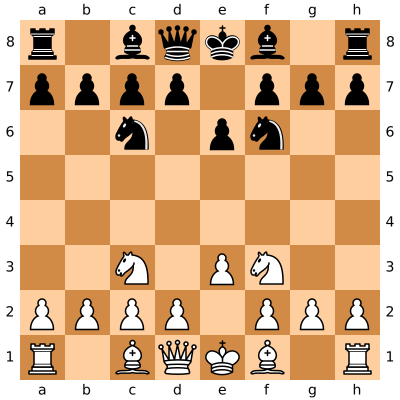

In [16]:
movehistory =[]
board = chess.Board()
mov = selectmove(3)
board.push(mov)
mov = selectmove(3)
board.push(mov)
mov = selectmove(3)
board.push(mov)
mov = selectmove(3)
board.push(mov)
mov = selectmove(3)
board.push(mov)
mov = selectmove(3)
board.push(mov)
SVG(chess.svg.board(board=board,size=400))

In [9]:
import random
import time

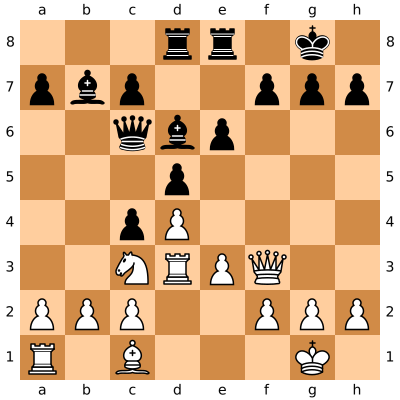

In [18]:
# and do random moves

board = chess.Board()
for i in range(30):
    # move = random.choice(list(board2.legal_moves)) # find legal move
    move = selectmove(3)
    board.push(move)
    # time.sleep(0.5)
SVG(chess.svg.board(board=board,size=400))

To make a human move you can use:

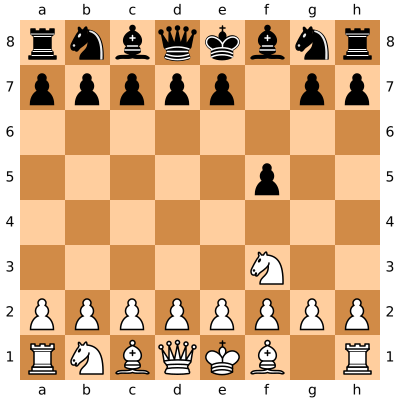

In [12]:
board.push_san("f5")
SVG(chess.svg.board(board=board,size=400))

## Match against Stockfish

Stockfish [https://stockfishchess.org/](https://stockfishchess.org/) is one of the strongest chess-engines in this days. I use it to test my programm with a search depth of 3.

After loading the Stockfish engine with the [UCI](https://www.chessprogramming.org/UCI) component of the library I wrote some code to collect all the moves of the game in a list ("movehistory") and write them to a [portable game notation file](https://en.wikipedia.org/wiki/Portable_Game_Notation). 

At the end of the game the final board position is displayed.

[Event "Example"]
[Site "Linz"]
[Date "2021-05-03"]
[Round "1"]
[White "MyChess"]
[Black "Stockfish9"]
[Result "0-1"]

1. Nf3 Nf6 2. Nc3 d5 3. e3 e6 4. d4 c5 5. Bd3 c4 6. Be2 a6 7. Bd2 b5 8. O-O Nc6 9. Ne5 Nxe5 10. dxe5 Nd7 11. f4 b4 12. Na4 Nc5 13. Nxc5 Bxc5 14. Bf3 Qb6 15. Re1 a5 16. Qe2 O-O 17. Kh1 Bd7 18. e4 Bb5 19. Be3 d4 20. Bc1 d3 21. cxd3 cxd3 22. Qd1 Bf2 23. Rf1 Bd4 24. a4 bxa3 25. Qd2 Rfc8 26. Rxa3 Rc2 27. Qd1 Qc5 28. Bd2 a4 29. b4 Qc4 30. Be1 d2 31. Bf2 Rc1 32. Bxd4 Qxf1+ 33. Qxf1 Rxf1+ 34. Bg1 Rxf3 35. Rxa4 Rxa4 36. gxf3 Bf1 37. Bc5 d1=Q 38. Kg1 Qxf3 39. Bf8 Qg2# 0-1


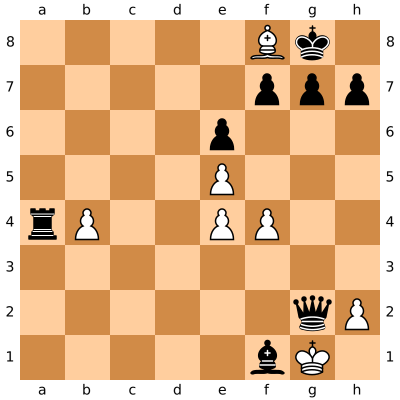

In [22]:
import chess.pgn
import datetime
import chess.uci

engine = chess.uci.popen_engine("./stockfish.exe")
engine.uci()
engine.name

movehistory =[]
game = chess.pgn.Game()
game.headers["Event"] = "Example"
game.headers["Site"] = "Linz"
game.headers["Date"] = str(datetime.datetime.now().date())
game.headers["Round"] = 1
game.headers["White"] = "MyChess"
game.headers["Black"] = "Stockfish9"
board = chess.Board()
while not board.is_game_over(claim_draw=True):
    if board.turn:
        move = selectmove(3)
        board.push(move)
    else:
        engine.position(board)
        move = engine.go(movetime=1000).bestmove
        movehistory.append(move)
        board.push(move)
    
game.add_line(movehistory)
game.headers["Result"] = str(board.result(claim_draw=True))
print(game)
print(game, file=open("test.pgn", "w"), end="\n\n")

SVG(chess.svg.board(board=board,size=400))

In the opening phase both programs used the opening books. Considering the limeted amount of knowledge of my program it played some solid moves. The end of the game showed the negative effects of the limited search depth of my engine. 

There are a lot of things that can be done to improve the stength of the program. For example a more sophisticated evaluation function or a better search procedure. I will cover this in future posts.

## Selfplay

In [ ]:
import chess.pgn
import datetime

movehistory =[]
game = chess.pgn.Game()
game.headers["Event"] = "Example"
game.headers["Site"] = "Linz"
game.headers["Date"] = str(datetime.datetime.now().date())
game.headers["Round"] = 1
game.headers["White"] = "MyChess"
game.headers["Black"] = "MyChess"
board = chess.Board()
while not board.is_game_over(claim_draw=True):
    if board.turn:
        move = selectmove(3)
        board.push(move)       
    else:
        move = selectmove(3)
        board.push(move)   
    
game.add_line(movehistory)
game.headers["Result"] = str(board.result(claim_draw=True))
print(game)
print(game, file=open("selftest.pgn", "w"), end="\n\n")

SVG(chess.svg.board(board=board,size=400))